**Week 3: CNN Cancer Detection Kaggle Mini-Project**

**Brief description of the problem and data (5 pts)**

**Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.**

The challenge with this project is to create a prgram that will load the images in the dataset, Build a CNN to analyse the pictures, and train it to identify whether or not the image is of a cancer cell. 
The pictures are split into two folder train and test, wiith the sample submission and training label csv files in the root directory.
The data is comprised of a training X set of pictures, a training y set of corresponding labels being a 0 or a 1, and a testing dataset consisting of only pictures.
The pictures provided apear to consist of 96 x 96 pixel 24 bit color RGB images of around 27kb each.
The description says the center 32x32 PX is where the image contains a positive cell. 
There are 220K images and coresponding labels in the training dataset, and 57.5K images in the testing dataset with no labels (accuracy determined after submitting).
It will be necesary to split the training set into X_train, y_train, X_test, y_test sets in order to validate the model before submission.



In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau

trainDF = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
trainDir = '/kaggle/input/histopathologic-cancer-detection/train/'
testDir = '/kaggle/input/histopathologic-cancer-detection/test/'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

My eda on the data will probaly be pretty simple. I will first plot a 5 images from the top of the list from each category. Make sure they are loading properly.
then I will check for any missing pictures from the label data, put a ring in the center 32x32 range where the positive diagnosis would lie. Finally I will plot a simple class distribution of the data to see the ratio of positive and negative datapoints.
As long as the data is clean, I don't see any possible further basic analysis given the data is a collection of images. 



samples from label 0: ['ddbb94ab204c1cfe8b5ab2800eec12103d62e23a'
 '16285b71823b47fb1fd122bf3ab62799707e13e8'
 '2bb2c2c9b1ed700656c68fa989e0b64d805eaa08'
 'efa95c12698fb516a9027b8c86d82c7ac35e5909'
 'd80cf54cffce2ef562e583e0236756fafb348684']
samples from label 1: ['ea22da391a19ec92547fade9417c1dc67fd03390'
 '7edead7418e66ceec2ab3234ad9b8824da604e84'
 '256c3f94fcc48d4c0075ddeb9e0693c41973f34f'
 '7228243c6d9cbabf59eb08eb2bca5e2f5367f580'
 'a396885426277fe8c524beed6c489dd4f508efb0']


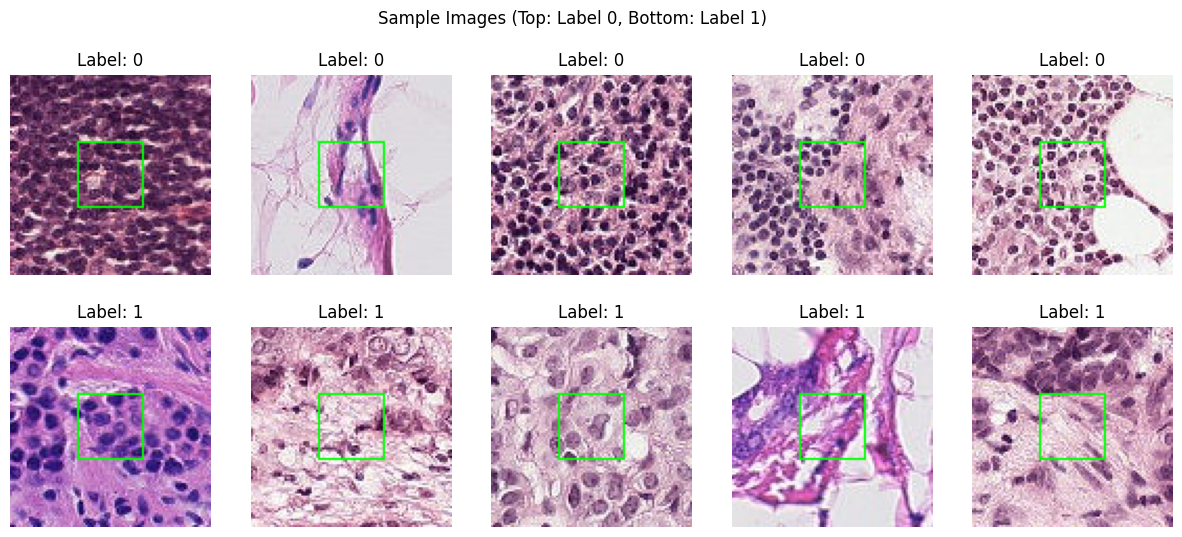

In [9]:
# Sample 5 images per classification type and display them
samp0 = trainDF[trainDF['label'] == 0].sample(5)['id'].values
samp1 = trainDF[trainDF['label'] == 1].sample(5)['id'].values

print(f'samples from label 0: {samp0}')
print(f'samples from label 1: {samp1}')

def display_samples(samples, label, start_idx):
    for i, img_id in enumerate(samples):
        img_path = os.path.join(trainDir, img_id + '.tif')
        img = np.array(Image.open(img_path))
        # Highlight center 32x32 in green outline (optional)
        center_start = (32, 32)  # Adjusted for 96x96
        center_end = (64, 64)
        img[center_start[0]:center_start[0]+1, center_start[1]:center_end[1]] = [0, 255, 0]  # Top
        img[center_end[0]-1:center_end[0], center_start[1]:center_end[1]] = [0, 255, 0]  # Bottom
        img[center_start[0]:center_end[0], center_start[1]:center_start[1]+1] = [0, 255, 0]  # Left
        img[center_start[0]:center_end[0], center_end[1]-1:center_end[1]] = [0, 255, 0]  # Right
        
        plt.subplot(2, 5, start_idx + i + 1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

# Plot
plt.figure(figsize=(15, 6))
display_samples(samp0, 0, 0)
display_samples(samp1, 1, 5)
plt.suptitle('Sample Images (Top: Label 0, Bottom: Label 1)')
plt.show()


In [10]:
missing = [id for id in trainDF['id'].sample(1000) if not os.path.exists(os.path.join(trainDir, id + '.tif'))]
print(f'Missing files: {len(missing)}') 

Missing files: 0


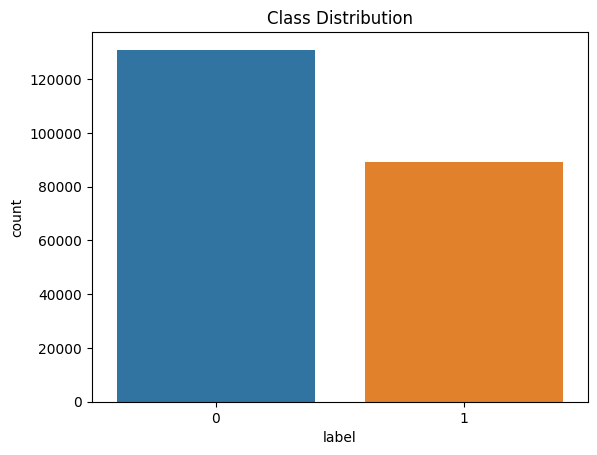

In [11]:
import seaborn as sns
sns.countplot(x='label', data=trainDF)
plt.title('Class Distribution')
plt.show()

Use ImageDataGenerator to automatically zoom, rotate, and shift the images to help prevent overfitting in the model. The images should change randomly with each epoch.

In [12]:
# Add an ID label for the picture 
trainDF['id'] = trainDF['id'] + '.tif'
trainDF['label'] = trainDF['label'].astype(str)  

# Split the train data into a train and validation set with stratification, with the random state being the answer to life the universe and everything.
train_DF, val_DF = train_test_split(
    trainDF, 
    test_size=0.2, 
    stratify=trainDF['label'], 
    random_state=42 
)

print(f"Training set: {len(train_DF)} samples")
print(f"Validation set: {len(val_DF)} samples")

# Training generator normalized and shuiffled.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_DF,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=128,
    class_mode='binary',
    shuffle=True
)

# Validation image generator for testing, no shuffling for testing.
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_DF,
    directory='/kaggle/input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

Training set: 176020 samples
Validation set: 44005 samples
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


**DModel Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

To start with I will split the training data into a train and validation set. After I will use ImageDataGenerator to normalize and shuffle the data for each epoch to help protect against overfitting. Then I will create a CNN starting with a couple convolution layers. Maybe add a pooling layer followed by a couple dense hidden layers before I run it to a single output. This should get me started, and will provide me with a better picture of what will be required in order to get a good result. I will likely need to add in some normalization and dropout on some layers to prevent overfitting and flatten the outputs of the convolution layers before sending to the hidden layer.

Start off by building an empty model

In [20]:

model = Sequential()
model.add(Input(shape=(96, 96, 3)))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Add a convolution layer with a 3x3 window, normalize the output, and downscale with a max pool by a factor of 2. 

In [21]:

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.summary() 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,024 (4.00 KB)

 Trainable params: 960 (3.75 KB)

 Non-trainable params: 64 (256.00 B)

Flatten the data from 2d to a 1d vector and run through a hidden dense layer and finaly through a single sigmoiid output neuron for binary classification.

In [22]:
# Convert to 1d vector
model.add(Flatten()) 
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │     2,262,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,105 (8.63 MB)

 Trainable params: 2,263,041 (8.63 MB)

 Non-trainable params: 64 (256.00 B)

Compile the model

In [23]:
# Coompile the model for training and validation
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
    #jit_compile=False 
)


Fit the model and plot some analysis of the accuracy.

Epoch 1/3
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1762s 1s/step - accuracy: 0.7537 - auc: 0.8189 - loss: 0.5119 - val_accuracy: 0.7402 - val_auc: 0.8412 - val_loss: 0.5057
Epoch 2/3
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 957s 695ms/step - accuracy: 0.7723 - auc: 0.8358 - loss: 0.4920 - val_accuracy: 0.7643 - val_auc: 0.8262 - val_loss: 0.5298
Epoch 3/3
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 978s 711ms/step - accuracy: 0.7762 - auc: 0.8436 - loss: 0.4814 - val_accuracy: 0.7518 - val_auc: 0.8244 - val_loss: 0.5931


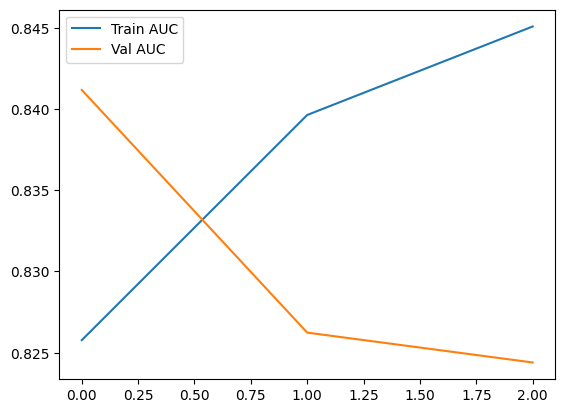

In [25]:
history = model.fit(
    train_generator,
    epochs=3,  # Start small, add more
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Plot results to test
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.show()


**Results and Analysis (35 pts)**

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Single convolution layer did do pretty well, but there are some overfitting issues, and training time is very expensive at almos 30 mins per epoch. I would like to rebuild the model with two more convolution/pooling layers to see if the performance improves. I will also increas the dropout to see if it helpos with the overfitting. But to start with I am going to see if the same model will benefit traing time wise with cropping the input of the conv network to 32x32.

In [ ]:
model = Sequential()

model.add(Input(shape=(96, 96, 3)))
model.add(Cropping2D(cropping=((32, 32), (32, 32))))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten()) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


In [8]:
# Coompile the model for training and validation
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
    #jit_compile=False 
)

In [9]:
history = model.fit(
    train_generator,
    epochs=10,  
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Plot results to test
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1753893989.655028     113 service.cc:148] XLA service 0x7cc10c087990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753893989.655839     113 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753893989.992458     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1376 ━━━━━━━━━━━━━━━━━━━━ 2:18:59 6s/step - accuracy: 0.5391 - auc: 0.5619 - loss: 0.8547

I0000 00:00:1753893992.186672     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1911s 1s/step - accuracy: 0.7470 - auc: 0.7988 - loss: 0.5790 - val_accuracy: 0.7833 - val_auc: 0.8450 - val_loss: 0.4804
Epoch 2/10
1204/1376 ━━━━━━━━━━━━━━━━━━━━ 1:28 517ms/step - accuracy: 0.7812 - auc: 0.8394 - loss: 0.4851

KeyboardInterrupt: 

This did work, and there was a graph, but due to notebook crash had to re-run notebook, and training time is still very high at about 20 - 30 mins per epoch. Will run the final model one more time to see if I can get a better result. Happy with 0.86, but would like to see if we can bump it up a bit.

Just realized im about out of GPU time for the week. Will give the model 1 final shot with a lowered epoch (10 instead of 25) and see how well it does. Might have to call it good enough on this one. 

In [13]:
model = Sequential()

model.add(Input(shape=(96, 96, 3)))
model.add(Cropping2D(cropping=((32, 32), (32, 32))))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(1, activation='sigmoid'))

model.summary()

I0000 00:00:1753905191.999091      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cropping2d (Cropping2D)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,449 (689.25 KB)

 Trainable params: 176,001 (687.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
import keras
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")
]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1753905200.880990     103 service.cc:148] XLA service 0x7cc398007620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753905200.881938     103 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753905201.511497     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1376 ━━━━━━━━━━━━━━━━━━━━ 4:13:10 11s/step - accuracy: 0.5000 - auc: 0.4558 - loss: 1.2741

I0000 00:00:1753905206.372682     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1591s 1s/step - accuracy: 0.7337 - auc: 0.7804 - loss: 0.5638 - val_accuracy: 0.7576 - val_auc: 0.8458 - val_loss: 0.5148 - learning_rate: 0.0010
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 731s 531ms/step - accuracy: 0.7821 - auc: 0.8374 - loss: 0.4837 - val_accuracy: 0.7631 - val_auc: 0.8326 - val_loss: 0.5049 - learning_rate: 0.0010
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 646s 470ms/step - accuracy: 0.7909 - auc: 0.8491 - loss: 0.4690 - val_accuracy: 0.7281 - val_auc: 0.7840 - val_loss: 0.5548 - learning_rate: 0.0010
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 668s 486ms/step - accuracy: 0.7980 - auc: 0.8587 - loss: 0.4549 - val_accuracy: 0.7416 - val_auc: 0.8427 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 722s 525ms/step - accuracy: 0.8015 - auc: 0.8662 - loss: 0.4438 - val_accuracy: 0.7748 - val_auc: 0.8467 - val_loss: 0.4753 - learning_rate: 8.0000e-04
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 658s 479ms/step -

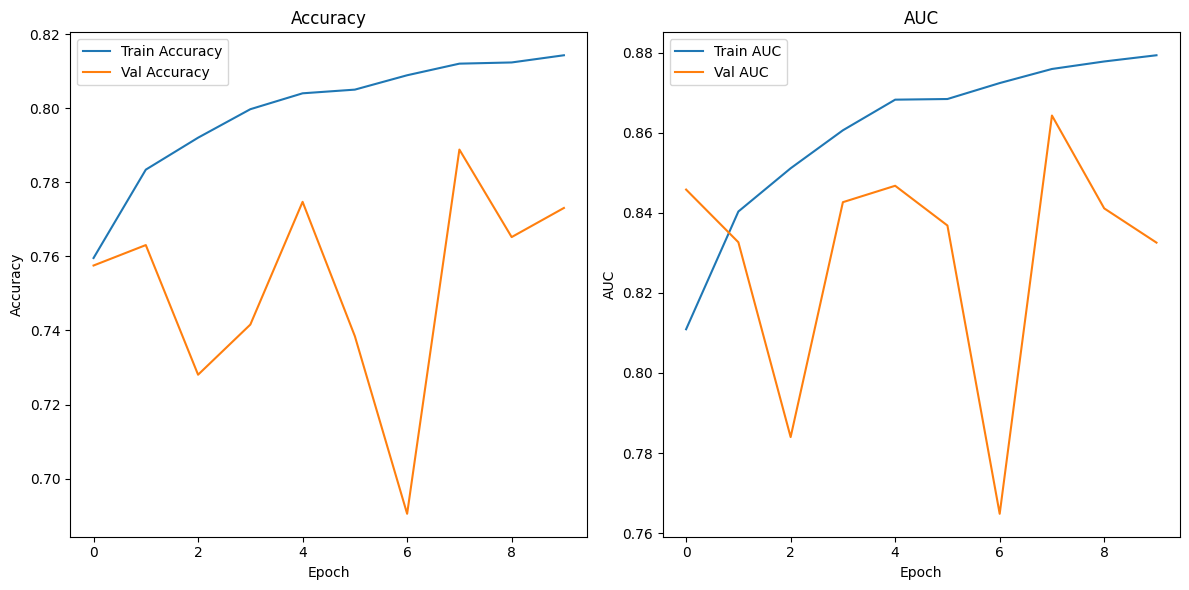

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')],
    jit_compile=True
)


history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

I have reworked this model multiple times, and am hitting a ceiling in training. Rigt around 86% accuracy. I think I would do better with longer training, but I have already buirned through an entire weeks quota on kaggle for GPU time. (30 hours, only 2 left). I did however add some call backs in that could help, including saving the best model, early stopping and reducing LR on plateau. Out of time and ideas, ready to throw in the towel on this one. Its been fun.

In [ ]:
test_files = os.listdir(testDir)
test_df = pd.DataFrame({
    'filename': test_files,
    'id': [f.split('.')[0] for f in test_files]
})

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=testDir,
    x_col='filename',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)


nb_samples = len(test_df)
predictions = model.predict(test_generator, steps=int(np.ceil(nb_samples / 32)))
test_df['label'] = predictions.flatten()
submission = test_df[['id', 'label']]
submission.to_csv('submission.csv', index=False)
print(submission.head())

**Conclusion (15 pts)**

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

After several iterations, using a few different hyperparameter tunings, I was able to produce a model capable of 86% accuracy. This is no where near top spot, but my biggest problem with this dataset is training time. If a I had several weeks and a few good GPUs I could probaly get a better result. As it stands, a 10 epoch training sesion takes up to 8 hours, and the model is generally no where near topped out I think. With my last model I reduced the input to the model using a cropping 2d layer. This means the model takes the full image, but only uses the center 32px. as the instructions from kaggle for this competition stated, that is the only part that was used for initial classification, and the rest is essentially padding. In the future for models like this, I will need to set aside more time each day to start a training run, and likely download the training data, the notebook, and run them on a local machine where I don't have to worry about a disconnect losing all my training data (this has happened twice on this project losing all outputs). With an average epoch time of around 30 minutes, A full training would take days or weeks on a GPU or better.    